In [1]:
include("../deps/dataProcessKit/dataProcessKit.jl")
using .dataProcessKit
include("../deps/dataProcessKit/myDraw.jl")
using .myDraw

In [2]:
clear()

In [3]:
geinf=jload("/path/to/annotation/mm10/Mus_musculus.GRCm38.79.gene.jld2")
geinf["scan_pos"]=rowfun(geinf["gene_pos"], geinf["strand"]) do p, s
    if s=='+'
        [p[1]-2000 p[1]+500]
    else
        @assert s=='-'
        [p[2]-500 p[2]+2000]
    end
end;

In [4]:
pkA=jload("merged_Insm1_peak_Adult.jld2")
gi, pi=genomemap(d"chrno, scan_pos"geinf, d"chrno, pos"pkA, touch=true)
geA=jload("../Insm1_KO_adult_RNAseq/adult_gene_DESeq2_test.jld2", showinfo=false)
geA["isInsm1"]=dtshift(geA["geneid"], geinf["geneid"], falsesbut(rnum(geinf), gi), safe=true);

In [5]:
pkE=jload("merged_Insm1_peak_E18.jld2")
gi, pi=genomemap(d"chrno, scan_pos"geinf, d"chrno, pos"pkE, touch=true)
geE=jload("../Insm1_KO_adult_RNAseq/E18_gene_DESeq2_test.jld2", showinfo=false)
rename!(geE, "raw_pvalue"=>"rawP", "padj"=>"FDR", "logFC"=>"lgFC")
geE["isInsm1"]=dtshift(geE["geneid"], geinf["geneid"], falsesbut(rnum(geinf), gi), safe=true);

In [6]:
geA["grp"]=@withrow geA begin
    if $rawP<0.05 && $lgFC<-log2(1.5)
        2
    elseif $rawP<0.05 && $lgFC>log2(1.5)
        2
    else
        1
    end
end;

In [7]:
geE["grp"]=@withrow geE begin
    if $rawP<0.05 && $lgFC<-log2(1.5)
        2
    elseif $rawP<0.05 && $lgFC>log2(1.5)
        2
    else
        1
    end
end;

In [8]:
(xA, nA)=grpfun(x->(count(x), length(x)), fastgrp(geA["grp"], 1:2), geA["isInsm1"]);
(xE, nE)=grpfun(x->(count(x), length(x)), fastgrp(geE["grp"], 1:2), geE["isInsm1"]);

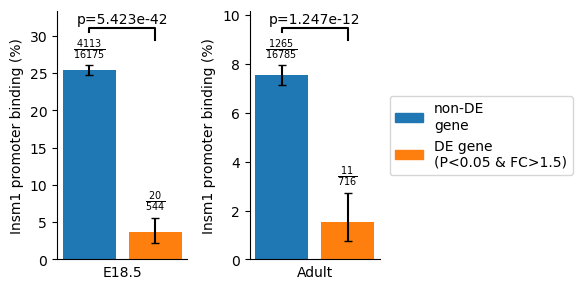

In [26]:
_, ax=subplots(1, 2, figsize=(4, 3))
sca(ax[2])
_, _, tx, ty=binobar(xA, nA, grp=1:2)
p=fishertest([xA nA.-xA])
barbrace((1, 2), maximum(ty)+ax_height(0.05), f"p=$(1=.4g)"(p), balance="<")

xticks([])
ylabel("Insm1 promoter binding (%)")
ylm=ylim()
yticks()[1]|>x->yticks(x, f"$1".(round.(Int, x.*100)))
ylim(ylm)
halfbox()
xlabel("Adult")

sca(ax[1])
_, _, tx, ty=binobar(xE, nE, grp=1:2)
p=fishertest([xE nE.-xE])
barbrace((1, 2), maximum(ty)+ax_height(0.05), f"p=$(1=.4g)"(p), balance="<")
xticks([])
ylabel("Insm1 promoter binding (%)")
ylm=ylim()
yticks()[1]|>x->yticks(x, f"$1".(round.(Int, x.*100)))
ylim(ylm)
halfbox()
xlabel("E18.5")

tight_layout()
sca(ax[2])
freelegend(c"C0[], C1[], C2[]", c"non-DE\ngene, DE gene\n(P<0.05 & FC>1.5)",
    loc=6, bbox_to_anchor=(1.02, 0.5))

pltsave("Insm1_repel_DE_genes_adultAndE18")

In [27]:
fishertest([1265 16785-1265; 11 716-11], vb=1)


	Fisher's Exact Test for Count Data

data:  structure(c(1265L, 11L, 15520L, 705L), .Dim = c(2L, 2L))
p-value = 1.247e-12
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.890897 10.541461
sample estimates:
odds ratio 
   5.22364 



1.246818661494306e-12

In [21]:
geA1=rec(geA, geA["grp"].==1)
geA2=rec(geA, geA["grp"].==2)
l1, l2=balancemask(meanh(log2.(geA1["FPKM"].+1)), meanh(log2.(geA2["FPKM"].+1)));
@assert all(l2)
geA1=rec(geA1, l1);

Group by 10 bins.


In [24]:
geE1=rec(geE, geE["grp"].==1)
geE2=rec(geE, geE["grp"].==2)
l1, l2=balancemask(meanh(log2.(geE1["FPKM"].+1)), meanh(log2.(geE2["FPKM"].+1)));
@assert all(l2)
geE1=rec(geE1, l1);

Group by 10 bins.


In [25]:
xA=[count(geA1["isInsm1"]), count(geA2["isInsm1"])]
nA=[rnum(geA1), rnum(geA2)]
xE=[count(geE1["isInsm1"]), count(geE2["isInsm1"])]
nE=[rnum(geE1), rnum(geE2)];

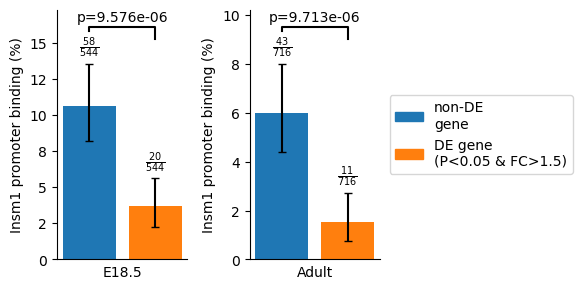

In [27]:
_, ax=subplots(1, 2, figsize=(4, 3))
sca(ax[2])
_, _, tx, ty=binobar(xA, nA, grp=1:2)
p=fishertest([xA nA.-xA])
barbrace((1, 2), maximum(ty)+ax_height(0.05), f"p=$(1=.4g)"(p), balance="<")

xticks([])
ylabel("Insm1 promoter binding (%)")
ylm=ylim()
yticks()[1]|>x->yticks(x, f"$1".(round.(Int, x.*100)))
ylim(ylm)
halfbox()
xlabel("Adult")

sca(ax[1])
_, _, tx, ty=binobar(xE, nE, grp=1:2)
p=fishertest([xE nE.-xE])
barbrace((1, 2), maximum(ty)+ax_height(0.05), f"p=$(1=.4g)"(p), balance="<")
xticks([])
ylabel("Insm1 promoter binding (%)")
ylm=ylim()
yticks()[1]|>x->yticks(x, f"$1".(round.(Int, x.*100)))
ylim(ylm)
halfbox()
xlabel("E18.5")

tight_layout()
sca(ax[2])
freelegend(c"C0[], C1[], C2[]", c"non-DE\ngene, DE gene\n(P<0.05 & FC>1.5)",
    loc=6, bbox_to_anchor=(1.02, 0.5))

pltsave("Insm1_repel_DE_genes_adultAndE18_balanced")